# The Graph Data Access

In this notebook, we read in the data that was generated and saved as a csv from the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook. 


Goals of this notebook are to obtain:

* Signals, states, event and sequences
* Volatility metrics
* ID perceived shocks (correlated with announcements)
* Signal for target price
* Signal for market price
* Error plot

As a starting point for moving to a decision support system.

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp


## Import data and add additional attributes

In [2]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [3]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,marketPriceEth,marketPriceUsd,redemptionPrice,timestamp,redemptionPriceActual,redemptionRateActual
0,11857308,1988.440433,1988.577499,0.002589,4.670500,"{'block': '11849022', 'id': '0xe313271188492c4...",1613338681,3.14,1.0
1,11860793,2788.440433,2788.617717,0.002481,4.377049,"{'block': '11860755', 'id': '0x40066774f6fb7d3...",1613384616,3.14,1.0
2,11861040,2788.440433,2788.657935,0.002481,4.406833,"{'block': '11861008', 'id': '0x0d551e2a2d55fa8...",1613387890,3.14,1.0
3,11861337,2788.440433,2788.657935,0.002481,4.419266,"{'block': '11861237', 'id': '0x5c67dbb323db039...",1613392101,3.14,1.0
4,11861474,3048.440433,3048.645955,0.001769,3.194330,"{'block': '11861237', 'id': '0x5c67dbb323db039...",1613394096,3.14,1.0


In [4]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,marketPriceEth,marketPriceUsd,timestamp,redemptionPriceActual,redemptionRateActual
count,5.330000e+02,5.330000e+02,5.330000e+02,533.000000,533.000000,5.330000e+02,533.000000,5.330000e+02
mean,1.193335e+07,2.540810e+07,2.591990e+07,0.002013,3.348852,1.614349e+09,3.094425,1.000000e+00
std,4.187935e+04,1.241339e+07,1.276372e+07,0.000312,0.518664,5.566735e+05,0.040308,1.531488e-08
min,1.185731e+07,1.988440e+03,1.988577e+03,0.001609,2.850455,1.613339e+09,3.018131,9.999999e-01
25%,1.189726e+07,1.381372e+07,1.382187e+07,0.001798,3.168261,1.613869e+09,3.057628,1.000000e+00
50%,1.193332e+07,3.254064e+07,3.349321e+07,0.001982,3.235196,1.614349e+09,3.107139,1.000000e+00
75%,1.196947e+07,3.435062e+07,3.527843e+07,0.002122,3.331552,1.614830e+09,3.130402,1.000000e+00
max,1.200566e+07,3.832670e+07,3.919798e+07,0.004474,8.055382,1.615311e+09,3.140000,1.000000e+00


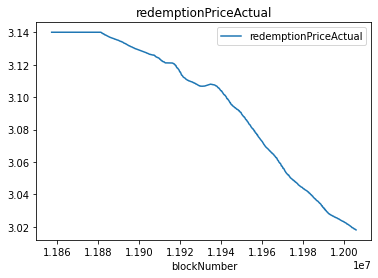

In [5]:
graphData.plot(x='blockNumber',y='redemptionPriceActual',kind='line',title='redemptionPriceActual')

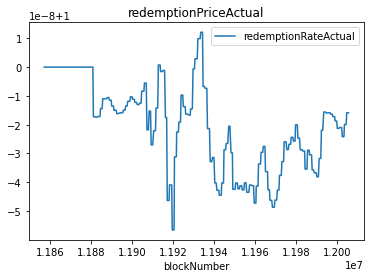

In [6]:
graphData.plot(x='blockNumber',y='redemptionRateActual',kind='line',title='redemptionPriceActual')

In [7]:
graphData['error'] = graphData['redemptionPriceActual'] - graphData['marketPriceUsd']
graphData['error_integral'] = graphData['error'].cumsum()

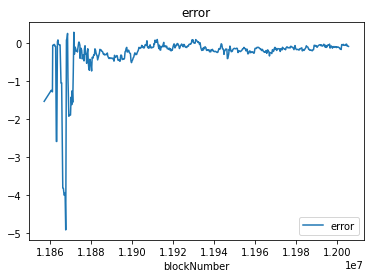

In [8]:
graphData.plot(x='blockNumber',y='error',kind='line',title='error')

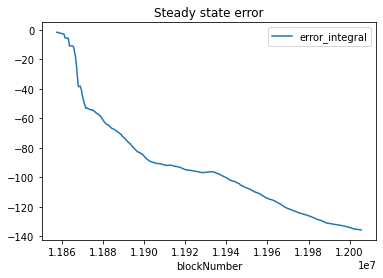

In [9]:
graphData.plot(x='blockNumber',y='error_integral',kind='line',title='Steady state error')

## Error experimentation

#### Note: not taking into account control period

In [10]:
kp = 2e-7
#ki = (-kp * error)/(integral_error)
# computing at each time, what would the value of ki need to be such that the redemption price would be constant
graphData['equilibriation_ki'] = (-kp * graphData.error)/graphData.error_integral

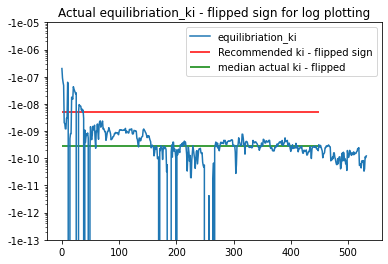

In [81]:
# todo iterate through labels and append negative
graphData['equilibriation_ki'].apply(lambda x: -x).plot(logy = True,title='Actual equilibriation_ki - flipped sign for log plotting')
plt.hlines(5e-9, 0, 450, linestyles='solid', label='Recommended ki - flipped sign', color='r')
plt.hlines(-(graphData['equilibriation_ki'].median()), 0, 450, linestyles='solid', label='median actual ki - flipped', color='g')
locs,labels = plt.yticks()  # Get the current locations and labelsyticks
new_locs = []
for i in locs:
    new_locs.append('-'+str(i))
plt.yticks(locs, new_locs)
plt.legend(loc="upper right")

In [12]:
graphData['equilibriation_ki'].median()

-2.8215076589497323e-10

### Counterfactual if intergral control rate had been median the whole time

In [13]:
graphData['counterfactual_redemption_rate'] = (kp * graphData['error'] + graphData['equilibriation_ki'].median())/ graphData['error_integral']

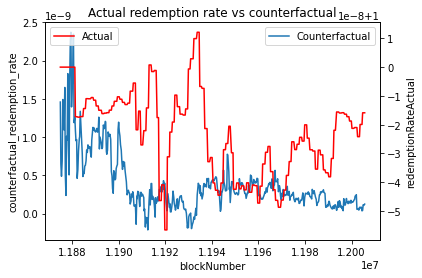

In [14]:
subsetGraph = graphData.iloc[50:]
sns.lineplot(data=subsetGraph,x="blockNumber", y="counterfactual_redemption_rate",label='Counterfactual')
ax2 = plt.twinx()
# let reflexer know this is wrong
sns.lineplot(data=subsetGraph,x="blockNumber", y="redemptionRateActual",ax=ax2,color='r',label='Actual')
plt.title('Actual redemption rate vs counterfactual')
plt.legend(loc="upper left")


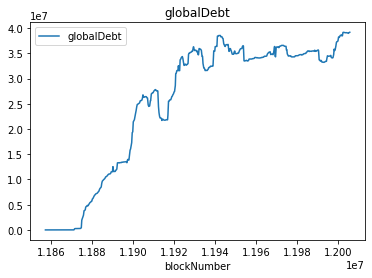

In [18]:
graphData.plot(x='blockNumber',y='globalDebt',kind='line',title='globalDebt')

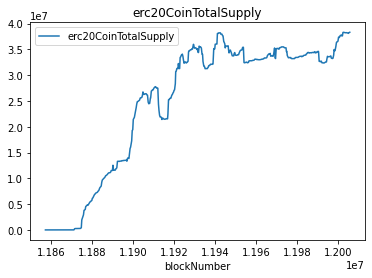

In [19]:
graphData.plot(x='blockNumber',y='erc20CoinTotalSupply',kind='line',title='erc20CoinTotalSupply')

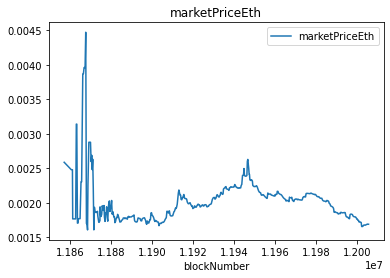

In [20]:
graphData.plot(x='blockNumber',y='marketPriceEth',kind='line',title='marketPriceEth')

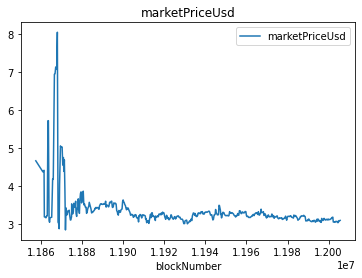

In [21]:
graphData.plot(x='blockNumber',y='marketPriceUsd',kind='line',title='marketPriceUsd')

## Conclusion

Using The Graph, a lot of data about the Rai system can be obtained for analyzing the health of the system. With some data manipulation, these data streams could be intergrated into the Rai cadCAD model to turn it into a true decision support system.